In [1]:
from Library import *
from Data_Preparation import *
#from Data_Preparation2 import *
import folium 
import scipy
import sklearn
from IPython.display import display
from sklearn import preprocessing
from itertools import combinations
import pickle
from sklearn import decomposition
from icecream import ic 
import os
from tqdm import tqdm
import requests
import nbimporter
from datetime import datetime
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc , roc_auc_score, r2_score, accuracy_score , silhouette_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from datetime import datetime, time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import DBSCAN
from IPython.display import Markdown, display
import geopandas as gpd
from shapely.geometry import Point
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
vehicle_id = 460631

# part 1 - preparing the patterned drives groups

function returns the area name by geographic information

In [3]:


def get_neighborhood_name(latitude, longitude):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
    
    try:
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code != 200:
#             print( f"Error: Received status code {response.status_code}")
            return get_neighborhood_name(latitude, longitude)

        
        # Parse the response JSON
        data = response.json()
        
        if 'address' in data:
            if 'neighbourhood' in data['address']:
                return data['address']['neighbourhood']
            elif 'suburb' in data['address']:
                return data['address']['suburb']
            elif 'town' in data['address']:
                return data['address']['town']
            elif 'city' in data['address']:
                return data['address']['city']
            else:
                return "Neighborhood not found"
        else:
            return "Neighborhood not found"
    
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    
    except ValueError as e:
        print(f"JSON decoding failed: {e}")

def get_geographic_info_opencage(latitude, longitude):
    key = 'ede7e3aada8147188172eef6bc3dd326'  # Replace with your OpenCage API key
    geocoder = OpenCageGeocode(key)
    result = geocoder.reverse_geocode(latitude, longitude, no_annotations='1', language='en')
    
    if result:
        location = result[0]
        components = location['components']
#         components = location
#         return components
        return {
            "neighborhood": components.get('neighbourhood') or components.get('suburb'),
            "suburb": components.get('suburb'),
            "city": components.get('city') or components.get('town'),
            "state": components.get('state'),
            "country": components.get('country'),
            "postal_code": components.get('postcode'),
            "road": components.get('road')
        }
    else:
        return {"error": "Location not found"}

from opencage.geocoder import OpenCageGeocode
def get_neighborhood_name(lat, lon, gdf=None, spatial_index=None):
#     # Create a Point object
#     point = Point(lon, lat)
    
#     # Use spatial index to get possible matches
#     possible_matches_index = list(spatial_index.intersection(point.bounds))
#     possible_matches = gdf.iloc[possible_matches_index]
    
#     # Check each candidate polygon for containment
#     for idx, neighborhood in possible_matches.iterrows():
#         if neighborhood['geometry'].contains(point):
#             dict_obj = json.loads(neighborhood['tags'])
#             if 'name:en'  in dict_obj:
#                 return dict_obj['name:en']
#             else:
#                 print(lat, lon)
    lat = str(lat)+'01'
    lon = str(lon)+'01'
    dict1 = get_geographic_info_opencage(lat,lon)
    return dict1["neighborhood"] if dict1["neighborhood"] else dict1["road"]
# Example usage:


latitude = 32.108205  # Example latitude
longitude = 34.823596  # Example longitude

neighborhood_name = get_neighborhood_name(latitude, longitude)
print("Neighborhood:", neighborhood_name)

Neighborhood: Hadar Yosef


function returns english translation 

In [4]:
# %pip install googletrans==4.0.0-rc1

from googletrans import Translator

def translate_hebrew_to_english(text):
    translator = Translator()
    translation = translator.translate(text, src='he', dest='en')
    return translation.text

# Example usage
hebrew_text = "שלום, איך אתה?"
english_text = translate_hebrew_to_english(hebrew_text)
print(english_text)  # Output: "Hello, how are you?"


Hello, how are you?


function that extract and saves the drives of some vehicle from the data 

In [5]:
def Prepare_metadata_by_vehicle_number(vehicle_ids = 460631):
    PATH_raw_data = '/data/inputs/Year_Data'
    vehicle_ids = [vehicle_ids]
    
    for year_str in ['2018','2019']:
        for month_index in tqdm(range(1, 13, 1)):
            if os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{month_index}_{year_str}_{vehicle_ids}_trips.pickle")\
    and os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{month_index}_{year_str}_{vehicle_ids}_car.csv"):
                continue
        
            months_metadata = pd.DataFrame(
                {'month_num_str': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
                 'month_shortcut_name': ['jan', 'feb', 'march', 'april', 'may', 'june', 'july', 'aug',
                                         'sep', 'oct', 'nov', 'dec'],
                 'days': [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]})
            if year_str == '2020':
                months_metadata['days'][1] = 29
            num_days = [int(np.floor((months_metadata.days[month_index - 1] - i) / 7 + 1)) for i in
                        range(1, 8, 1)]  # calculate number of days in each day of the week

            drives1, gps1, _ = read_same_trips('01', months_metadata.month_num_str[month_index - 1], year_str, num_days[0],
                                               directory=PATH_raw_data + '/')  # Saturdays of July
            drives1, gps1 = drives1.loc[drives1['VEHICLE_ID'].isin(vehicle_ids)], gps1.loc[gps1['vehicle_id'].isin(vehicle_ids)]
            drives1['START_DRIVE'] = pd.to_datetime(drives1['START_DRIVE'])
            drives1['END_DRIVE'] = pd.to_datetime(drives1['END_DRIVE'])
            gps1['orig_time'] = pd.to_datetime(gps1['orig_time'])

            drives2, gps2, _ = read_same_trips('02', months_metadata.month_num_str[month_index - 1], year_str, num_days[1],
                                               directory=PATH_raw_data + '/')  # Sundays of July
            drives2, gps2 = drives2.loc[drives2['VEHICLE_ID'].isin(vehicle_ids)], gps2.loc[gps2['vehicle_id'].isin(vehicle_ids)]
            drives2['START_DRIVE'] = pd.to_datetime(drives2['START_DRIVE'])
            drives2['END_DRIVE'] = pd.to_datetime(drives2['END_DRIVE'])
            gps2['orig_time'] = pd.to_datetime(gps2['orig_time'])

            drives3, gps3, _ = read_same_trips('03', months_metadata.month_num_str[month_index - 1], year_str, num_days[2],
                                               directory=PATH_raw_data + '/')  # Mondays of July
            drives3, gps3 = drives3.loc[drives3['VEHICLE_ID'].isin(vehicle_ids)], gps3.loc[gps3['vehicle_id'].isin(vehicle_ids)]
            drives3['START_DRIVE'] = pd.to_datetime(drives3['START_DRIVE'])
            drives3['END_DRIVE'] = pd.to_datetime(drives3['END_DRIVE'])
            gps3['orig_time'] = pd.to_datetime(gps3['orig_time'])

            drives4, gps4, _ = read_same_trips('04', months_metadata.month_num_str[month_index - 1], year_str, num_days[3],
                                               directory=PATH_raw_data + '/')  # Tuesdays of July
            drives4, gps4 = drives4.loc[drives4['VEHICLE_ID'].isin(vehicle_ids)], gps4.loc[gps4['vehicle_id'].isin(vehicle_ids)]
            drives4['START_DRIVE'] = pd.to_datetime(drives4['START_DRIVE'])
            drives4['END_DRIVE'] = pd.to_datetime(drives4['END_DRIVE'])
            gps4['orig_time'] = pd.to_datetime(gps4['orig_time'])

            drives5, gps5, _ = read_same_trips('05', months_metadata.month_num_str[month_index - 1], year_str, num_days[4],
                                               directory=PATH_raw_data + '/')  # Wendsdays of July
            drives5, gps5 = drives5.loc[drives5['VEHICLE_ID'].isin(vehicle_ids)], gps5.loc[gps5['vehicle_id'].isin(vehicle_ids)]
            drives5['START_DRIVE'] = pd.to_datetime(drives5['START_DRIVE'])
            drives5['END_DRIVE'] = pd.to_datetime(drives5['END_DRIVE'])
            gps5['orig_time'] = pd.to_datetime(gps5['orig_time'])

            drives6, gps6, _ = read_same_trips('06', months_metadata.month_num_str[month_index - 1], year_str, num_days[5],
                                               directory=PATH_raw_data + '/')  # Theursdays of July
            drives6, gps6 = drives6.loc[drives6['VEHICLE_ID'].isin(vehicle_ids)], gps6.loc[gps6['vehicle_id'].isin(vehicle_ids)]
            drives6['START_DRIVE'] = pd.to_datetime(drives6['START_DRIVE'])
            drives6['END_DRIVE'] = pd.to_datetime(drives6['END_DRIVE'])
            gps6['orig_time'] = pd.to_datetime(gps6['orig_time'])

            drives7, gps7, _ = read_same_trips('07', months_metadata.month_num_str[month_index - 1], year_str, num_days[6],
                                               directory=PATH_raw_data + '/')  # Fridays of July
            drives7, gps7 = drives7.loc[drives7['VEHICLE_ID'].isin(vehicle_ids)], gps7.loc[gps7['vehicle_id'].isin(vehicle_ids)]
            drives7['START_DRIVE'] = pd.to_datetime(drives7['START_DRIVE'])
            drives7['END_DRIVE'] = pd.to_datetime(drives7['END_DRIVE'])
            gps7['orig_time'] = pd.to_datetime(gps7['orig_time'])

            drives = pd.concat([drives1, drives2, drives3, drives4, drives5, drives6, drives7], ignore_index=True)
            gps = pd.concat([gps1, gps2, gps3, gps4, gps5, gps6, gps7], ignore_index=True)

            trip_len_min = 10
            drives_sub_group = drives.loc[drives['DRIVE_DURATION'] >= trip_len_min]
            
            trips_lst = separate_to_drives(drives_sub_group, gps)
            with open(
                    f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{month_index}_{year_str}_{vehicle_ids}_trips.pickle",
                    'wb') as handle:
                pickle.dump(trips_lst, handle)
            
            
            drives_sub_group.to_csv(
                f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{month_index}_{year_str}_{vehicle_ids}_car.csv",
                mode='w', index=False)
Prepare_metadata_by_vehicle_number()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17822.82it/s]


uploading the meta data of each drive by specific car number

In [6]:
df = concated_data_with_feat(vehicle_id)
df.columns = df.columns.str.upper()

In [7]:
# Convert all column names in the DataFrame to uppercase
df.columns = df.columns.str.upper()

# Extract the hour part from the "START_DRIVE" column and store it in a new column "START_HOUR"
df["START_HOUR"] = pd.to_datetime(df["START_DRIVE"]).dt.hour

# Extract the hour part from the "END_DRIVE" column and store it in a new column "END_HOUR"
df["END_HOUR"] = pd.to_datetime(df["END_DRIVE"]).dt.hour

# Extract the date (without time) from the "START_DRIVE" column and store it in a new column "DATE"
df["DATE"] = pd.to_datetime(df["START_DRIVE"]).dt.date

# Create a new column "DAY_OF_WEEK" that contains the day of the week (e.g., Monday, Tuesday)
df["DAY_OF_WEEK"] = df["DATE"].apply(lambda x: x.strftime("%A"))

# Set the index of the DataFrame to the values of the "DRIVE_ID" column
df.index = df['DRIVE_ID']

# Drop the "START_DRIVE" and "END_DRIVE" columns as they are no longer needed
df = df.drop(["START_DRIVE", "END_DRIVE"], axis=1)

# Initialize the NEIGHBORHOOD column with None or empty values
df['end_NEIGHBORHOOD'] = None
df['start_NEIGHBORHOOD'] = None

# # Iterate over rows with tqdm progress bar
# for idx, row in tqdm(df.iterrows(), total=len(df)):
#     df.at[idx, 'end_NEIGHBORHOOD'] = get_neighborhood_name(
#         round(row['END_LATITUDE'], 4), 
#         round(row['END_LONGITUDE'], 4)
#     )
#     df.at[idx, 'start_NEIGHBORHOOD'] = get_neighborhood_name(
#         round(row['START_LATITUDE'], 4), 
#         round(row['START_LONGITUDE'], 4)
#     )
    
# df_for_decision_tree = df[['end_NEIGHBORHOOD','start_NEIGHBORHOOD',
#                            'DAY_OF_WEEK','DATE','VEHICLE_ID','DRIVE_ID',
#                            'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE',
#                            'END_LONGITUDE','END_HOUR','START_HOUR']]


In [8]:
# Create a copy of the original DataFrame `df` to avoid modifying the original data
grouped_df = df.copy()

# Round the "START_LATITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["START_LATITUDE"] = grouped_df["START_LATITUDE"].round(3)

# Round the "START_LONGITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["START_LONGITUDE"] = grouped_df["START_LONGITUDE"].round(3)

# Round the "END_LATITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["END_LATITUDE"] = grouped_df["END_LATITUDE"].round(3)

# Round the "END_LONGITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["END_LONGITUDE"] = grouped_df["END_LONGITUDE"].round(3)

# Group the DataFrame by the rounded "END_LATITUDE" and "END_LONGITUDE" columns
# Count the number of occurrences (drives) for each unique pair of latitude and longitude
# Reset the index and store the result in a new column named 'num_drives' 
grouped_df = grouped_df.groupby(['END_LATITUDE', 'END_LONGITUDE']).size().reset_index(name='num_drives')


In [9]:
most_driven_cor = grouped_df.sort_values(by='num_drives', ascending=False).iloc[0]
# Extract latitude and longitude from the selected row
latitude = most_driven_cor['END_LATITUDE']
longitude = most_driven_cor['END_LONGITUDE']

# Create a tuple of the most driven coordinates
home_cor = (latitude, longitude)

agg_drives_filt = grouped_df[(grouped_df['num_drives'] > 7)&((grouped_df['END_LATITUDE']!=latitude) & (grouped_df['END_LONGITUDE']!=longitude))].sort_values(by=[ 'num_drives'], ascending=[ False])

# agg_drives_filt = agg_drives_filt[(agg_drives_filt['START_LATITUDE'] != agg_drives_filt['END_LATITUDE'])&(agg_drives_filt['START_LONGITUDE'] != agg_drives_filt['END_LONGITUDE'])]
agg_drives_filt['NEIGHBORHOOD'] = agg_drives_filt.apply(lambda row: get_neighborhood_name(row['END_LATITUDE'], row['END_LONGITUDE']), axis=1)
agg_drives_filt

END_LATITUDE  END_LONGITUDE  num_drives         NEIGHBORHOOD
139        32.113         34.818         174          Hadar Yosef
154        32.116         34.802          98  Tel Aviv University
414        32.188         34.846          71             Naot Uzi
245        32.158         34.795          58               HaOgen
124        32.110         34.807          54  Tel Aviv University
150        32.115         34.818          35         Neot Afeka A
404        32.185         34.853          28             Rom 2000
343        32.168         34.857          19            Neve Amal
225        32.150         34.846          19             Tsamarot
408        32.186         34.853          17             Rom 2000
441        32.230         34.844          17                 5513
151        32.115         34.819          17         Neot Afeka A
459        32.264         34.835          16              2 North
359        32.171         34.825          16           Herzliya B
444        32.232         34.824          16                 5517
306        32.166         34.824          14           Herzliya B
400        32.184         34.853          13             Rom 2000
350        32.169         34.856          13            Neve Amal
410        32.187         34.847          12             Naot Uzi
307        32.166         34.825          12           Herzliya B
147        32.115         34.802          12  Tel Aviv University
314        32.166         34.859          11            Neve Amal
183        32.136         34.841          11           Neve Rasko
482        32.307         34.878          10        משכנות זבולון
52         32.040         35.047           9                שלב ד
371        32.173         34.855           9            Neve Amal
160        32.119         34.837           9              Tzahala
332        32.168         34.800           8     Herzliya Pituach

In [10]:
# def tag_drives(agg_drives, driver=1):
#     # Copy DataFrame and initialize 'driver' column
#     drives_df = agg_drives.copy()
#     drives_df['driver'] = 0
#     driver_dict = {}

#     # Assign driver tags based on conditions
#     for i in range(len(drives_df)):
#         if i == 0:
#             drives_df.at[drives_df.index[i], 'driver'] = driver
#             driver_dict[drives_df.index[i]] = drives_df.iloc[i]
#         else:
#             match = False
#             for j, previous_row in driver_dict.items():
#                 if (
#                     drives_df.at[drives_df.index[i], 'NEIGHBORHOOD'] == previous_row['NEIGHBORHOOD']
# #                     and drives_df.at[drives_df.index[i], 'START_HOUR'] == previous_row['START_HOUR']
#                 ):
#                     drives_df.at[drives_df.index[i], 'driver'] = driver
#                     match = True
#                     break
#             if not match:
#                 driver_dict[drives_df.index[i]] = drives_df.iloc[i]

#     return drives_df[drives_df['driver'] == 1], drives_df[drives_df['driver'] == 0]

# def get_drives(df, drives_group, with_returns=True):
#     # Vectorized join on rounded coordinates to identify matches in drives
#     rounded_drives = df.copy()
#     rounded_drives['END_LATITUDE'] = rounded_drives['END_LATITUDE'].round(3)
#     rounded_drives['END_LONGITUDE'] = rounded_drives['END_LONGITUDE'].round(3)
#     rounded_group = drives_group[['END_LATITUDE', 'END_LONGITUDE']].round(3)

#     # Merge to find matches efficiently
#     matching_df = rounded_drives.merge(rounded_group, on=['END_LATITUDE', 'END_LONGITUDE'], how='inner')
#     matching_drives = matching_df.index.tolist()

#     if with_returns:
#         # Filter further by checking return drives starting from matched end coordinates
#         potential_returns = rounded_drives[
#             rounded_drives[['START_LATITUDE', 'START_LONGITUDE']].round(3).isin(
#                 rounded_drives.loc[matching_drives, ['END_LATITUDE', 'END_LONGITUDE']].round(3)
#             ).all(axis=1)
#         ]
#         potential_returns = potential_returns[potential_returns['DATE'].isin(
#             rounded_drives.loc[matching_drives, 'DATE']
#         )]
#         matching_drives.extend(potential_returns.index.tolist())

#     return matching_drives

# # Initialize dictionaries for results
# dict_drives = {}
# dict_sum = {}
# dict_cor = {}

# # Copy filtered DataFrame
# agg_drives2 = agg_drives_filt.copy()

# # Driver tagging loop
# i = 1
# while len(agg_drives2) > 1:
#     tag_drives_group, agg_drives2 = tag_drives(agg_drives2)

#     driver1_lst = get_drives(df, tag_drives_group)
#     driver1_df = df.loc[driver1_lst, ['END_LATITUDE', 'END_LONGITUDE']]
#     sum_drives = len(driver1_df)

#     if sum_drives > 0:
#         dict_cor[i] = (float(tag_drives_group.iloc[0]['END_LATITUDE']),
#                        float(tag_drives_group.iloc[0]['END_LONGITUDE']))
#         dict_sum[i] = sum_drives
#         dict_drives[i] = driver1_df

#     i += 1

# # Sort and reorder dictionaries by drive counts
# dict_sum = dict(sorted(dict_sum.items(), key=lambda item: item[1], reverse=True))
# sorted_keys = dict_sum.keys()
# dict_cor = {k: dict_cor[k] for k in sorted_keys}
# dict_drives = {k: dict_drives[k] for k in sorted_keys}

# print(dict_sum)


## The tag_drives function
takes a DataFrame agg_drives, which contains aggregated drive data, and tags each drive based on the neighborhood, assigning a specific driver tag (1 or 0). The function returns two DataFrames:

Drives tagged as 1 (associated with the given driver).
Drives tagged as 0 (not associated with the given driver).

## The get_drives function
takes two DataFrames, df and drives_group, and returns a list of indices of the drives that match based on their ending coordinates (and optionally include return drives that start from the matching ending coordinates). It’s designed to find "matching" drives between two groups.

In [11]:
def tag_drives(agg_drives,driver=1):
    drives_df = agg_drives.copy()
    drives_df['driver'] = 0
    driver_dict = {}
#     agg_drives.at[3263176, 'driver'] = 0
    for i, row in drives_df.iterrows():
#         agg_drives.at[i, 'driver'] = int(0)
        if  i == drives_df.index[0]:
            drives_df.at[i, 'driver'] = driver
            driver_dict[i] = row
        else:
            for j in driver_dict:
                if (
                    row['NEIGHBORHOOD'] == driver_dict[j]['NEIGHBORHOOD']):
#                     and row['END_LATITUDE'] == driver_dict[j]['END_LATITUDE']
#                     and row['END_LONGITUDE'] == driver_dict[j]['END_LONGITUDE'] ):

                        drives_df.at[i, 'driver'] = driver
                        break  # Exit the loop once a match is found
    return drives_df[drives_df['driver']==1] , drives_df[drives_df['driver']==0]

def get_drives(df, drives_group, with_returns=True):   
    # List to store indices of matching drives
    matching_drives = []

    # Iterate over each row in the dataframe and drives_group
    for index_df, row_df in df.iterrows():
        for index_dg, row_dg in drives_group.iterrows():
            # Check if the end coordinates of the current drive in df match
            # the end coordinates of the current drive in drives_group
            if (round(row_df['END_LATITUDE'], 3) == row_dg['END_LATITUDE'] and
                round(row_df['END_LONGITUDE'], 3) == row_dg['END_LONGITUDE']):
                # If match found, append index of the drive in df to matching_drives
                matching_drives.append(index_df)
                # Break the inner loop as we've found a match
                break

    if with_returns:
        # Iterate over the filtered dataframe (df) based on matching indices
        for index_df, row_df in df[df.index.isin(matching_drives)].iterrows():
            # Iterate again over the entire dataframe to find drives starting where
            # the matching drives end and on the same date
            for index, row in df.iterrows():
                if (round(row_df['END_LATITUDE'], 3) == round(row['START_LATITUDE'], 3) and
                    round(row_df['END_LONGITUDE'], 3) == round(row['START_LONGITUDE'], 3) and
                    row_df['DATE'] == row['DATE']):
                    # If conditions match, append index of the drive in df to following_drives
                    matching_drives.append(index)
                    break
    
    return matching_drives

# Initialize three dictionaries to store results:
# - dict_drives: stores DataFrames of filtered drives for each group
# - dict_sum: stores the count of drives for each group
# - dict_cor: stores the coordinates (latitude, longitude) for the first drive in each group
dict_drives = {}
dict_sum = {}
dict_cor = {}

# Make a copy of the filtered drives DataFrame (agg_drives_filt) to preserve the original data
agg_drives2 = agg_drives_filt.copy()

# Initialize a counter `i` to label different driver groups
i = 1

# Loop until there is only one drive left in the agg_drives2 DataFrame
while len(agg_drives2) > 1:
    
    # Tag the drives in the remaining DataFrame (agg_drives2), separating the current group of drives
    # `tag_drives_group`: the drives tagged with the current driver (1)
    # `agg_drives2`: the remaining drives not yet tagged (driver 0)
    tag_drives_group, agg_drives2 = tag_drives(agg_drives2)
    
    # Get a list of drive indices from the original DataFrame (df) that match the coordinates of the tagged group
    driver1_lst = get_drives(df, tag_drives_group)
    
    # Create a new DataFrame (driver1_df) that contains only the matching drives from the cleaned DataFrame
    # - Filter columns to keep only the first 15 columns from `columns_og` along with 'END_LATITUDE' and 'END_LONGITUDE'
    driver1_df = df[df.index.isin(driver1_lst)][ ['END_LATITUDE', 'END_LONGITUDE']]
    
    # Calculate the total number of drives (rows) in this group
    sum_drives = len(driver1_df)
    
    # If the group contains any drives, proceed to record data
    if sum_drives > 0:
        
        # Store the coordinates (latitude, longitude) of the first drive in the group
        dict_cor[i] = (float(tag_drives_group.head(1)['END_LATITUDE']), float(tag_drives_group.head(1)['END_LONGITUDE']))
        
        # Store the count of drives in the current group
        dict_sum[i] = sum_drives
        
        # Store the DataFrame of drives for the current group
        dict_drives[i] = driver1_df
    
    # Increment the counter `i` for the next group
    i += 1

# Sort the `dict_sum` dictionary by the number of drives in descending order
# - This step ensures that the groups with the largest number of drives come first
dict_sum = {k: v for k, v in sorted(dict_sum.items(), key=lambda item: item[1], reverse=True)}

# Reorder `dict_cor` based on the sorted keys of `dict_sum`, so that the coordinates are consistent with the sorted groups
dict_cor = {k: dict_cor[k] for k in dict_sum.keys()}

# Reorder `dict_drives` similarly, to match the sorted group order
dict_drives = {k: dict_drives[k] for k in dict_sum.keys()}

# Print the final `dict_sum`, which contains the number of drives for each group
print(dict_sum)


{1: 312, 2: 307, 3: 155, 5: 102, 6: 102, 4: 96, 11: 80, 7: 58, 9: 34, 8: 31, 10: 31, 12: 24, 13: 21, 14: 19, 15: 18, 16: 10}


In [12]:
keys_to_delete = [key for key, value in dict_sum.items() if value < 60]
for key in keys_to_delete:
    del dict_sum[key]
    del dict_drives[key]
    del dict_cor[key]

print(dict_sum)

{1: 312, 2: 307, 3: 155, 5: 102, 6: 102, 4: 96, 11: 80}


In [13]:
def remap_keys(dicts):
    # Find the minimum key in all dictionaries
    min_key = min(min(d) for d in dicts)
    # Create a mapping from old keys to new keys
    key_mapping = {old_key: idx + min_key for idx, old_key in enumerate(sorted(set.union(*map(set, dicts))))}
    # Remap keys in all dictionaries
    remapped_dicts = [{key_mapping[key]: value for key, value in d.items()} for d in dicts]
    return tuple(remapped_dicts)

In [14]:
lst = remap_keys([dict_sum, dict_drives, dict_cor])
dict_sum =lst[0]
dict_drives = lst[1]
dict_cor = lst[2]

In [15]:
dict_sum = {k: v for k, v in sorted(dict_sum.items(), key=lambda item: item[1], reverse=True)}

dict_cor = {k: dict_cor[k] for k in dict_sum.keys()}
dict_drives = {k: dict_drives[k] for k in dict_sum.keys()}

In [16]:
neigh_dict = {}
for group in dict_cor:
    neigh_dict[group] = get_neighborhood_name(dict_cor[group][0], dict_cor[group][1])
    print("Neighborhood:", neigh_dict[group],group)

Neighborhood: Hadar Yosef 1
Neighborhood: Tel Aviv University 2
Neighborhood: Naot Uzi 3
Neighborhood: Neot Afeka A 5
Neighborhood: Rom 2000 6
Neighborhood: HaOgen 4
Neighborhood: Herzliya B 7


{1:              END_LATITUDE  END_LONGITUDE
 DRIVE_ID                                
 12780871732     32.112949      34.818027
 12783169309     32.115543      34.801804
 12867037216     32.113037      34.818085
 12869678760     32.115597      34.801857
 12788178154     32.112789      34.817978
 ...                   ...            ...
 52882299109     32.165470      34.857658
 52929179990     32.112865      34.817959
 52930860048     32.165527      34.857662
 52775002229     32.112904      34.818085
 52777636775     32.143196      34.792717
 
 [312 rows x 2 columns],
 2:              END_LATITUDE  END_LONGITUDE
 DRIVE_ID                                
 12783169309     32.115543      34.801804
 12783576327     32.165531      34.857620
 12869678760     32.115597      34.801857
 12870202242     32.165489      34.857838
 15955381442     32.109589      34.806656
 ...                   ...            ...
 52861959495     32.112892      34.818020
 52814524588     32.109772      34.806984
 

# part 2 processing the time series data

In [17]:
def acceleration_estimation(trip_record):
    """
    Estimate the acceleration with the speed data.
    :param trip_record: data frame with the original GPS meta-data
    :return: trip_record data frame with new columns - prev_time, next_time, prev_speed, next_speed,
                acceleration_est_1/2/3
    """
    trip_record['orig_time'] = pd.to_datetime(trip_record['orig_time'])
    trip_record['prev_time'] = trip_record['orig_time'].shift(1)
    trip_record['next_time'] = trip_record['orig_time'].shift(-1)
    trip_record['prev_time'] = pd.to_datetime(trip_record['prev_time'])
    trip_record['next_time'] = pd.to_datetime(trip_record['next_time'])
    trip_record['prev_speed'] = trip_record['speed'].shift(1)
    trip_record['next_speed'] = trip_record['speed'].shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    trip_record['acceleration_est_1'] = trip_record.apply(lambda row: (row['next_speed'] - row['prev_speed']) /
                                                                      (row['next_time'] - row['prev_time']).seconds
                                                          , axis=1)
    trip_record.at[trip_record.index[0], 'acceleration_est_1'] = (trip_record['next_speed'].iloc[0] -
                                                                  trip_record['speed'].iloc[0]) / \
                                                                 (trip_record['next_time'].iloc[0] -
                                                                  trip_record['orig_time'].iloc[0]).seconds
    trip_record.at[trip_record.index[-1], 'acceleration_est_1'] = (trip_record['speed'].iloc[-1] -
                                                                   trip_record['prev_speed'].iloc[-1]) / \
                                                                  (trip_record['orig_time'].iloc[-1]
                                                                   - trip_record['prev_time'].iloc[-1]).seconds
    """trip_record['acceleration_est_2'] = trip_record.apply(lambda row: (row['speed'] - row['prev_speed']) /
                                                                      (row['orig_time'] - row['prev_time']).seconds,
                                                          axis=1)
    trip_record['acceleration_est_3'] = trip_record.apply(lambda row: (row['next_speed'] - row['speed']) /
                                                                      (row['next_time'] - row['orig_time']).seconds
                                                          , axis=1)"""
    return trip_record


def angular_acc_estimation(trip_record):
    """
    create the angular acc estimation
    :param trip_record: data frame having the shifted columns from the acceleration estimation function.
    :return: 3 new columns to the trip data frame - prev direction, next direction, and angular acc.
    """
    # trip_no_idle = trip_record.copy()
    trip_record = trip_record.copy().loc[~((trip_record['orig_time'] == trip_record['prev_time']) |
                                           (trip_record['orig_time'] == trip_record['next_time']))]
    trip_record['prev_direction'] = trip_record.direction.shift(1)
    trip_record['next_direction'] = trip_record.direction.shift(-1)
    # trip_record['prev_time'] = trip_record.orig_time.shift(1)
    # trip_record['next_time'] = trip_record.orig_time.shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    
 
    # Calculate angular acceleration
    trip_record['angular_acc'] = trip_record.apply(lambda row:
                                                   (row['next_direction'] - 2 * row['direction'] + row['prev_direction']) /
                                                   ((row['next_time'] - row['orig_time']).total_seconds() * 
                                                    (row['orig_time'] - row['prev_time']).total_seconds()), axis=1)
    
    return trip_record

In [18]:
def trip_on_map(df):
    # Create a map object
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Define colors for markers
    colors = {2: 'green', 0: 'blue', 1: 'red', 3: 'orange', 4: 'pink', 5: 'teal', 6: 'maroon', 7: 'lavender'}

    color = colors[0]
    j = 0 


    for i, row in df.iterrows():
        if row['speed'] == 0:
            color = colors[1]
            rad = 8
        else:
            color = colors[0]
            rad = 5
        lat, lon = row['latitude'], row['longitude']
        folium.CircleMarker(location=[lat, lon], radius=rad, color=color, fill=True, fill_color=color).add_to(m)

    # Display the map
    return m

In [19]:
all_trips = []
for year in ['2018','2019']:
        for month in range(1,13,1): 

            with open(f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{str(month)}_{year}_[{vehicle_id}]_trips.pickle", 'rb') as handle:
                    trips_lst = pickle.load(handle)
            for trip in trips_lst[0]:
                
                trip.time_series_record.drop_duplicates(subset=['orig_time'], keep=False)
#                 curr_trip = speed_estimation(trip.time_series_record)
                curr_trip = acceleration_estimation(trip.time_series_record)
                curr_trip =angular_acc_estimation(curr_trip)
                curr_trip = curr_trip[(curr_trip['vehicle_state'] == 1) | (curr_trip['vehicle_state'] == 2)]
                curr_trip['date'] = curr_trip['orig_time'].dt.date
                curr_trip['hour'] = curr_trip['orig_time'].dt.time
                curr_trip['drive_id'] = trip.id
                
                curr_trip.drop(['prev_time',
                       'next_time','prev_speed','next_speed','prev_direction',
                      'next_direction','mileage','vehicle_id'],axis=1,inplace=True)
                curr_trip.fillna(0, inplace=True)
                all_trips.append(curr_trip)


In [20]:
drives_lst = [list(dict_drives[group].index) for group in dict_drives]

In [21]:
# Initialize variables for tracking:
# - min_df: This will store the drive series with the minimum length
# - minimum: Stores the minimum length encountered so far, initialized to 180
# - lengths: A list that will store the lengths of all the filtered trips
min_df = 0
minimum = 180
lengths = []

# Filter the trips from the list `all_trips` based on two conditions:
# - The length of each trip (series) should be between 70 and 300
# - The maximum speed of the trip should be greater than 0, or the maximum vehicle state should be less than 2
# This filtering ensures that only relevant trips (i.e., trips with non-zero speed or specific vehicle states) are selected
filtered_trips = [series for series in all_trips if (len(series) > 70 and len(series) < 300) 
                  and (np.max(series.speed) > 0 or np.max(series.vehicle_state) < 2)]

# Print the total number of filtered trips after applying the conditions
print('the amount of filtered drives:', len(filtered_trips))

# Iterate over each trip in the filtered list `filtered_trips`
for series in filtered_trips:
    # Get the length of the current trip (series) and store it in `len_cur`
    len_cur = len(series)
    
    # Append the length of the current trip to the `lengths` list
    lengths.append(len_cur)
    
    # Check if the current trip's length is smaller than the current minimum length
    if len_cur < minimum:
        # If a smaller length is found, update `minimum` with the new minimum length
        minimum = len_cur
        
        # Store the current trip (series) as the new `min_df` (the shortest trip encountered so far)
        min_df = series


the amount of filtered drives: 2220


In [22]:
# Initialize an empty list to store the filtered time series drives (ts_drives)
ts_drives = []

# Iterate over each trip in the filtered list of trips (filtered_trips)
for trip in filtered_trips:
    
    # Iterate over each index (ind) in the list of drive indices (drives_lst)
    for ind in drives_lst:
        
        # Check if the mean of the 'drive_id' values in the current trip exists in the index (ind)
        # This is used to determine if the trip's 'drive_id' is relevant to one of the drives in drives_lst
        if np.mean(trip.drive_id) in ind:
            
            # Round the 'speed' values in the trip DataFrame to the nearest whole number (0 decimal places)
            trip['speed'] = round(trip['speed'], 0)
            
            # Append the modified trip DataFrame to the list ts_drives
            ts_drives.append(trip)

# Print the total number of trips that were appended to ts_drives after the filtering process
print(len(ts_drives))


912


In [23]:
# Initialize an empty dictionary to store the time series grouped by the group number
groups_ts = {}

# Iterate over each group in the dict_drives dictionary
# 'group' represents the key (group number) in dict_drives, which corresponds to a specific set of drives
for group in dict_drives:
    
    # For each group, iterate over each row (drive) in the DataFrame corresponding to that group
    # 'ind' represents the index of the row, and 'row' represents the row data itself
    for ind, row in dict_drives[group].iterrows():
        
        # Iterate over each time series in the ts_drives list (which contains filtered time series drives)
        for series in ts_drives:
            
            # Check if the mean of the 'drive_id' in the time series matches the index (ind) from the group
            # This is used to associate the time series with the group if the 'drive_id' matches
            if np.mean(series.drive_id) == ind:
                
                # Get the list of time series for the current group from the dictionary
                # If the group doesn't exist in groups_ts yet, initialize it as an empty list
                groups_ts[group] = groups_ts.get(group, [])
                
                # Append the matching time series to the group's list in the groups_ts dictionary
                groups_ts[group].append(series)
                
                # Break the inner loop to stop checking other series once a match is found for the current 'ind'
                break


In [24]:
def split_dataframe(df):
    # Initialize an empty list to store lists of indices that will represent individual DataFrames
    lst = []
    
    # Initialize an empty list to collect indices of the current drive segment
    df_indices = []

    # Iterate over each row of the DataFrame
    for i, row in df.iterrows():
        try:
            # Check if the current row's speed is 0 and the next row's speed is greater than 0
            # This condition is used to detect a transition from stationary to movement
            if row.speed == 0 and df.loc[i + 1].speed > 0:
                # If the condition is met, append the collected indices of the current segment to lst
                lst.append(df_indices)
                
                # Reset df_indices to start collecting indices for the next segment
                df_indices = []
        
        # Handle the case where there is no next row (to avoid KeyError on the last row)
        except KeyError:
            pass
        
        # Append the current index (i) to df_indices, as part of the ongoing segment
        df_indices.append(i)

    # After the loop, append the last segment's indices to lst (since the loop ends without appending)
    lst.append(df_indices)

    # Create a list of DataFrames by splitting the original DataFrame based on the collected indices
    # Each set of indices in lst is used to filter rows from the original DataFrame
    # Exclude any empty lists of indices (if any)
    dataframes = [df[df.index.isin(indices)] for indices in lst if indices]

    # Return the list of DataFrames
    return dataframes


In [25]:
# Initialize an empty list to store all the split trips
splitted_ts_drives = []

# Iterate over each trip in the ts_drives list
for trip in ts_drives:
    # Use the split_dataframe function to split the current trip into sub-trips
    sub_trips_lst = split_dataframe(trip)
    
    # Iterate over each sub-trip generated from the split
    for sub_trip in sub_trips_lst:
        # Append each sub-trip to the list of splitted_ts_drives
        splitted_ts_drives.append(sub_trip)



In [26]:
leng_dict = {}
for i in lengths:
    leng_dict[i] = leng_dict.get(i,0) + 1

In [27]:
# Initialize a dictionary to hold the processed time series data for each group
group_ts_for_dbscan = {}

# Iterate over each group in groups_ts
for group in groups_ts:
    # Ensure the group key exists in group_ts_for_dbscan, initializing with an empty list if not
    group_ts_for_dbscan[group] = group_ts_for_dbscan.get(group, [])
    
    # Iterate over each series (trip) in the current group
    for series in groups_ts[group]:
        # Identify changes in latitude and longitude by comparing the current and previous row values
        series['lat_change'] = series['latitude'].shift() != series['latitude']
        series['lon_change'] = series['longitude'].shift() != series['longitude']

        # Combine the change indicators into a single column
        series['change'] = series['lat_change'] | series['lon_change']

        # Shift the change indicator to mark the last unchanged row
        series['keep'] = series['change'].shift(-1, fill_value=True)

        # Keep only the rows that are marked for keeping (unchanged until the next change)
        series = series[series['keep']]
        
        # Drop the helper columns used for calculations, as they are no longer needed
        series.drop(columns=['lat_change', 'lon_change', 'change', 'keep'], inplace=True)

        # Estimate acceleration for the series
        acceleration_estimation(series)
        
        # Estimate angular acceleration for the series
        angular_acc_estimation(series)

        # Drop unnecessary columns that are not needed for DBSCAN processing
        series.drop(columns=['vehicle_state', 'date', 'direction', 'prev_time', 'next_time', 'prev_speed', 'next_speed'], inplace=True)
        
        # Remove any rows with missing values to ensure clean data for clustering
        series.dropna(inplace=True)

        # Append the processed series to the corresponding group in group_ts_for_dbscan
        group_ts_for_dbscan[group].append(series)


In [28]:
# Initialize a dictionary to hold the split time series data for each group
splitted_ts_groups = {}

# Iterate over each group in the dictionary containing time series data for DBSCAN
for group in group_ts_for_dbscan:
    # Iterate over each DataFrame (time series) in the current group
    for curr_df in group_ts_for_dbscan[group]:
        # Ensure the current group key exists in splitted_ts_groups, initializing with an empty list if not
        splitted_ts_groups[group] = splitted_ts_groups.get(group, [])
        
        # Split the current DataFrame into smaller segments based on defined criteria in the split_dataframe function
        # and append the resulting segments to the list for the current group
        splitted_ts_groups[group] = splitted_ts_groups[group] + split_dataframe(curr_df)


In [29]:
def normalize_time_series(df_list):
    # Ensure all DataFrames in the list have the same shape by resetting their indices
    for df in df_list:
        df.reset_index(inplace=True, drop=True)

    # Concatenate all DataFrames along a new axis (rows)
    concatenated = pd.concat(df_list, axis=0)
    
    # Specify the columns of interest for normalization
    columns_of_interest = ['speed', 'acceleration_est_1', 'angular_acc']

    # Group by index and calculate the mean and standard deviation for the specified columns
    grouped = concatenated[columns_of_interest].groupby(concatenated.index)
    mean_series = grouped.mean()  # Calculate mean for each index
    std_series = grouped.std()    # Calculate standard deviation for each index
    
    # Replace any zero standard deviations with one to avoid division by zero during normalization
    std_series = std_series.replace(0, 1)

    # Initialize a list to hold the normalized DataFrames
    normalized_list = []
    
    # Normalize each DataFrame in the original list according to the calculated mean and standard deviation
    for df in df_list:
        normalized_df = df.copy()  # Create a copy of the current DataFrame
        index_values = normalized_df.index  # Get the index values of the current DataFrame
        
        # Normalize each column of interest based on its index value
        for col in columns_of_interest:
            # Apply normalization: (value - mean) / std_dev
            normalized_df[col] = (normalized_df[col] - mean_series.loc[index_values, col]) / std_series.loc[index_values, col]
        
        # Append the normalized DataFrame to the list
        normalized_list.append(normalized_df)
    
    # Return the list of normalized DataFrames
    return normalized_list


In [30]:
drives_hours = {1:[7,8,9,10,19,20,21,22,23],2:[11,12,13,14,15,16,17,18],3:[0,1,2,3,4,5,6]}

In [31]:
scaling_parameters = {}  # Initialize an empty dictionary to store scaling parameters

# Iterate over each group in the splitted time series groups
for group in splitted_ts_groups:
    # Iterate over each series in the current group
    for series in splitted_ts_groups[group]:
        series['group'] = group  # Assign the current group to the 'group' column in the series
        length = len(series)  # Get the length of the current series

        # Check if the length of the series is between 5 and 40
        if 5 < length < 40:
            road_speed = series.iloc[0]['road_speed']  # Get the road speed from the first row of the series
            
            # Determine the hour group based on the hour of the first entry in the series
            for h in drives_hours:
                if int(series.iloc[0]['hour'].hour) in drives_hours[h]:
                    group_hour = h  # Assign the hour group based on the drives_hours

            # Create a tuple of parameters: (length, road_speed, group_hour)
            scaling_parameters[(length, road_speed, group_hour)] = scaling_parameters.get((length, road_speed, group_hour), [])
            # Append the current series to the list of series corresponding to the parameters
            scaling_parameters[(length, road_speed, group_hour)].append(series)


In [32]:
new_dict = {key: scaling_parameters[key]  for key in scaling_parameters if len(scaling_parameters[key])>30}

In [33]:
dict_length = {}
for group in groups_ts:
    for se in groups_ts[group]:
        curr_len = len(se)
        se['group'] = group
        dict_length[curr_len] = dict_length.get(curr_len,[])
        dict_length[curr_len].append(se)

In [34]:
groups_splitted_normlized_ts = {}
for key in new_dict:
    lst = normalize_time_series(new_dict[key])
    for series in lst:
        group_num = int(series.iloc[0][['group']])
        groups_splitted_normlized_ts[group_num] = groups_splitted_normlized_ts.get(group_num,[])
        groups_splitted_normlized_ts[group_num].append(series)

In [35]:
dict_length = {}
for group in groups_splitted_normlized_ts:
    for series in groups_splitted_normlized_ts[group]:
        curr_len = len(series)
        if curr_len>=9:
            dict_length[curr_len] = dict_length.get(curr_len,[])
            dict_length[curr_len].append(series)

In [71]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate

# Define the convert_dfs_to_arrays function
def convert_dfs_to_arrays(df_list):
    arrays = []
    labels = []
    for df in df_list:
        arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
        labels.append(df.iloc[0]['group'])
    return np.stack(arrays, axis=0), labels

t_labels = []
X_transformed_list = []  # List to store all transformed arrays

for key in dict_length:
    arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
    t_labels += true_labels
    # Create the MiniRocketMultivariate transformer
    rocket = MiniRocketMultivariate(num_kernels=10000)  # Adjust num_kernels as needed

    # Fit the transformer on your data
    rocket.fit(arrays)

    # Transform the data
    X_transformed = rocket.transform(arrays)

    # Append the transformed data to the list
    X_transformed_list.append(X_transformed)

# Concatenate all transformed arrays along the first axis
X_transformed_all = np.concatenate(X_transformed_list, axis=0)

In [72]:

# Create a DataFrame from X_transformed_all
df_transformed = pd.DataFrame(X_transformed_all)

# Add a new column 'group' where each row gets the corresponding label from t_labels
df_transformed['group'] = t_labels

# Now df_transformed has the transformed features along with the group labels
df_transformed.head()


0         1         2         3         4         5         6  \
0  0.181818  0.545455  0.090909  0.272727  0.545455  0.181818  0.454545   
1  0.363636  0.545455  0.181818  0.363636  0.636364  0.363636  0.363636   
2  0.181818  0.545455  0.090909  0.272727  0.636364  0.181818  0.363636   
3  0.181818  0.454545  0.181818  0.181818  0.545455  0.181818  0.363636   
4  0.454545  0.545455  0.454545  0.454545  0.545455  0.454545  0.454545   

          7         8         9  ...      9987      9988      9989      9990  \
0  0.000000  0.181818  0.545455  ...  0.666667  1.000000  1.000000  0.666667   
1  0.000000  0.363636  0.545455  ...  0.000000  0.000000  0.333333  0.000000   
2  0.090909  0.272727  0.636364  ...  0.000000  0.666667  1.000000  0.000000   
3  0.000000  0.181818  0.454545  ...  0.666667  1.000000  1.000000  0.666667   
4  0.363636  0.454545  0.545455  ...  1.000000  1.000000  1.000000  1.000000   

       9991      9992      9993      9994      9995  group  
0  1.000000  1.000000  1.000000  1.000000  0.666667      1  
1  0.333333  0.333333  0.000000  0.333333  0.000000      1  
2  1.000000  1.000000  0.666667  1.000000  0.000000      1  
3  1.000000  1.000000  1.000000  1.000000  0.666667      1  
4  1.000000  1.000000  1.000000  1.000000  1.000000      1  

[5 rows x 9997 columns]

In [73]:
from sklearn.decomposition import PCA

# Apply PCA to the transformed data, keeping the first 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_transformed_all)

# Create a DataFrame from the PCA result
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Add the 'group' labels to the DataFrame
df_pca['group'] = t_labels

# Now df_pca contains the first 3 principal components and the group labels
df_pca.head()  # Preview the DataFrame


PC1       PC2       PC3  group
0  -4.138865  1.023769 -1.046257      1
1   7.554421 -7.725037  0.020206      1
2   1.976798  1.899628 -2.750653      1
3 -11.391210 -3.814158 -2.955205      1
4  -7.515512  8.433713 -4.865507      1

# part 3 - outliars detection and clustering

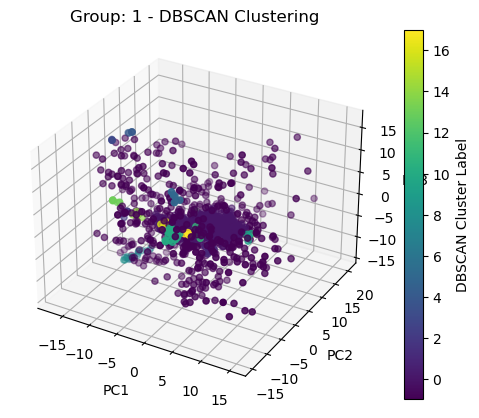

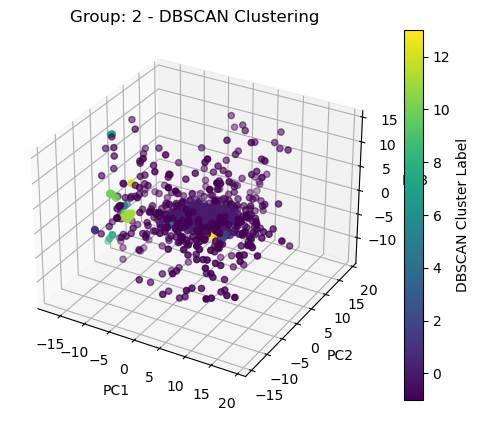

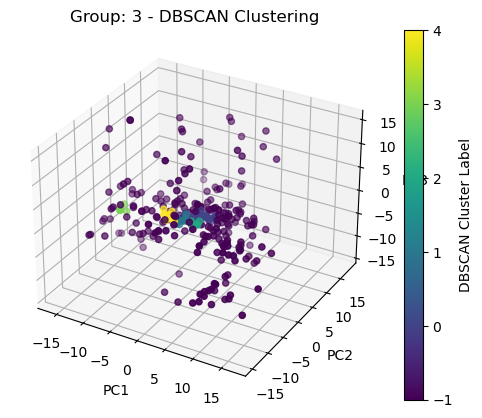

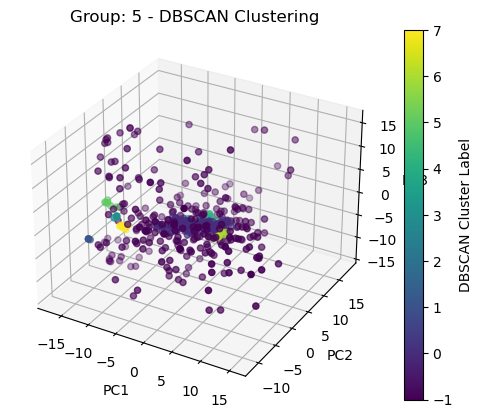

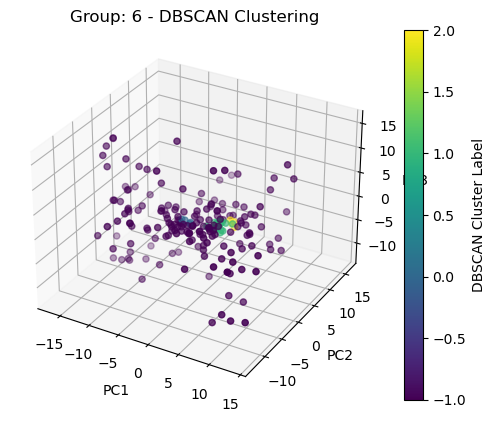

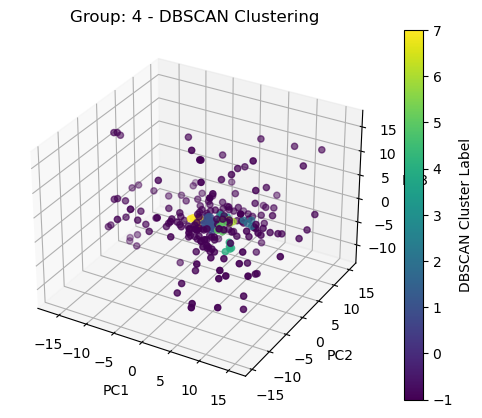

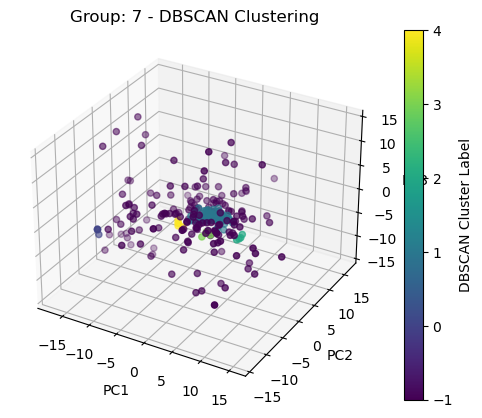

In [74]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply DBSCAN and plot for each group
def apply_dbscan_and_plot(df, eps=1.1, min_samples=4):
    # Get unique groups
    unique_groups = df['group'].unique()

    # Iterate over each group
    for group in unique_groups:
        # Filter the data for the current group
        group_data = df[df['group'] == group]

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels

        # Plot 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(group_data['PC1'], group_data['PC2'], group_data['PC3'],
                             c=group_data['dbscan_label'], cmap='viridis', label=group)

        ax.set_title(f"Group: {group} - DBSCAN Clustering")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

        # Add colorbar for the DBSCAN cluster labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('DBSCAN Cluster Label')

        # Show the plot
        plt.show()

# Assuming df_pca is already defined as in the previous step
apply_dbscan_and_plot(df_pca)


In [75]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Step 1: Identify the largest cluster and calculate mean and std for each group
def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=5)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]

        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1', 'PC2', 'PC3']].mean().values,
            'std': largest_cluster[['PC1', 'PC2', 'PC3']].std().values
        }

    return group_stats

group_stats = calculate_stats_for_largest_cluster(df_pca)
# pprint(group_stats)

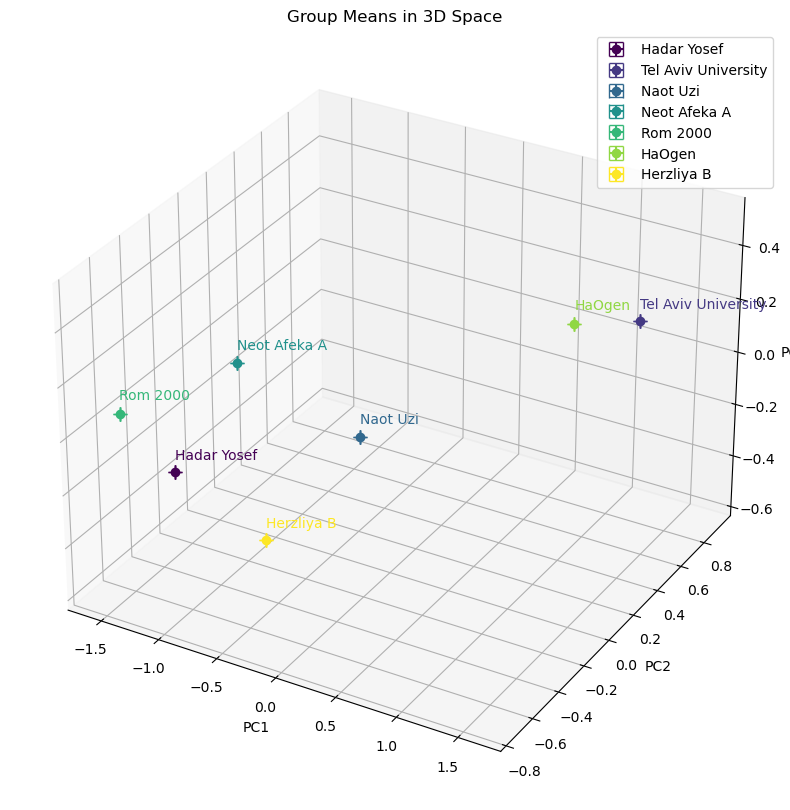

In [76]:
from mpl_toolkits.mplot3d import Axes3D

# file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_neighbors.pickle"

# # Read the pickle file
# with open(file_path, 'rb') as handle:
#     neighbors_dict = pickle.load(handle)

neighbors_dict = neigh_dict
# Extract means and stds from group_stats
means = np.array([stats['mean'] for stats in group_stats.values()])
stds = np.array([stats['std'] for stats in group_stats.values()])
group_labels = list(group_stats.keys())

# Define a color map (you can adjust the colormap as needed)
colors = plt.cm.viridis(np.linspace(0, 1, len(group_labels)))

# Create a larger 3D plot (adjusting figsize)
fig = plt.figure(figsize=(12, 10))  # Increase the size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot means with error bars, using different colors for each group
for i, label in enumerate(group_labels):
    ax.errorbar(means[i, 0], means[i, 1], means[i, 2], 
#                   xerr=stds[i, 0], yerr=stds[i, 1], zerr=stds[i, 2], 
                 xerr=0, yerr=0, zerr=0, 
                fmt='o', color=colors[i], label=neighbors_dict[label], capsize=5)

# Annotate each point with its group label
for i, label in enumerate(group_labels):
    ax.text(means[i, 0], means[i, 1], means[i, 2]+0.05, neighbors_dict[label], size=10, zorder=1, color=colors[i])

# Set labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Group Means in 3D Space')

# Show legend
ax.legend()

# Show the plot
plt.show()


K-Means Clustering (k = 2):
Group: Hadar Yosef, Cluster: 1
Group: Tel Aviv University, Cluster: 0
Group: Naot Uzi, Cluster: 0
Group: Neot Afeka A, Cluster: 1
Group: Rom 2000, Cluster: 1
Group: HaOgen, Cluster: 0
Group: Herzliya B, Cluster: 1

GMM Clustering (k = 2):
Group: Hadar Yosef, Cluster: 1
Group: Tel Aviv University, Cluster: 0
Group: Naot Uzi, Cluster: 0
Group: Neot Afeka A, Cluster: 1
Group: Rom 2000, Cluster: 1
Group: HaOgen, Cluster: 0
Group: Herzliya B, Cluster: 1

DBSCAN Clustering:
Group: Hadar Yosef, Cluster: 0
Group: Tel Aviv University, Cluster: 1
Group: Naot Uzi, Cluster: 2
Group: Neot Afeka A, Cluster: 3
Group: Rom 2000, Cluster: 3
Group: HaOgen, Cluster: 4
Group: Herzliya B, Cluster: 3


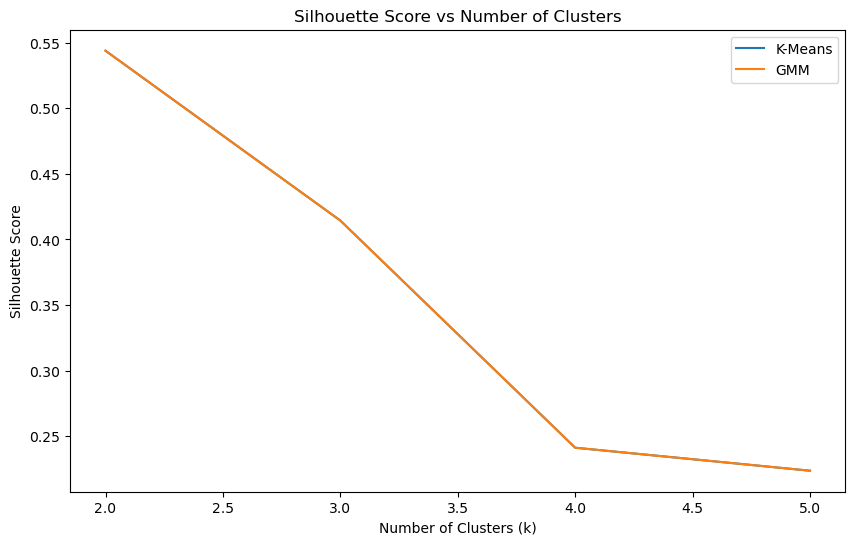

In [70]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Extract the means from the group_stats for clustering
X_means = np.array([stats['mean'] for stats in group_stats.values()])
group_labels = list(group_stats.keys())

# Function to evaluate silhouette scores for K-Means and GMM
def evaluate_clusterings(X, max_k=5):
    silhouette_scores_kmeans = []
    silhouette_scores_gmm = []
    
    for k in range(2, max_k + 1):
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)
        kmeans_silhouette = silhouette_score(X, kmeans_labels)
        silhouette_scores_kmeans.append(kmeans_silhouette)

        # GMM
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm_labels = gmm.fit_predict(X)
        gmm_silhouette = silhouette_score(X, gmm_labels)
        silhouette_scores_gmm.append(gmm_silhouette)

    return silhouette_scores_kmeans, silhouette_scores_gmm

# Evaluate silhouette scores
silhouette_scores_kmeans, silhouette_scores_gmm = evaluate_clusterings(X_means)

# Determine the best k for K-Means and GMM based on silhouette scores
best_k_kmeans = np.argmax(silhouette_scores_kmeans) + 2  # Add 2 because k starts from 2
best_k_gmm = np.argmax(silhouette_scores_gmm) + 2

# Apply K-Means and GMM with the best k
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_means)

gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
gmm_labels = gmm.fit_predict(X_means)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.1, min_samples=1)
dbscan_labels = dbscan.fit_predict(X_means)

# Print the clustering results
print("K-Means Clustering (k = {}):".format(best_k_kmeans))
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {kmeans_labels[i]}")

print("\nGMM Clustering (k = {}):".format(best_k_gmm))
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {gmm_labels[i]}")

print("\nDBSCAN Clustering:")
for i, group in enumerate(group_labels):
    print(f"Group: {neighbors_dict[group]}, Cluster: {dbscan_labels[i]}")

# Plotting the silhouette scores for K-Means and GMM
import matplotlib.pyplot as plt

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(silhouette_scores_kmeans) + 2), silhouette_scores_kmeans, label='K-Means')
plt.plot(range(2, len(silhouette_scores_gmm) + 2), silhouette_scores_gmm, label='GMM')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()


In [43]:
import random
def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=5)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1','PC2', 'PC3','PC4','PC5']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]

        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].mean().values,
            'std': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].std().values
        }

    return group_stats
# def calculate_stats_for_largest_cluster(df):
#     group_stats = {}
    
#     # Find the size of the smallest group
#     smallest_group_size = min(df['group'].value_counts())
#     sample_size = round(2/3 * smallest_group_size)
    
#     for group in df['group'].unique():
#         group_data = df[df['group'] == group]
        
#         # Randomly sample 2/3 of the size of the smallest group from this group
#         sampled_group_data = group_data.sample(n=sample_size, random_state=42)
        
#         # Perform DBSCAN clustering
#         dbscan = DBSCAN(eps=1, min_samples=5)
#         dbscan_labels = dbscan.fit_predict(sampled_group_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
        
#         # Add DBSCAN labels to the sampled DataFrame
#         sampled_group_data['dbscan_label'] = dbscan_labels
        
#         # Get the largest cluster
#         largest_cluster_label = sampled_group_data['dbscan_label'].value_counts().idxmax()
#         largest_cluster = sampled_group_data[sampled_group_data['dbscan_label'] == largest_cluster_label]
        
#         # Calculate mean and std of features in the largest cluster
#         group_stats[group] = {
#             'mean': largest_cluster[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean().values,
#             'std': largest_cluster[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].std().values
#         }
#     return group_stats
# import numpy as np

# def calculate_stats_for_sampled_group(df):
#     group_stats = {}
    
#     # Find the size of the smallest group
#     smallest_group_size = min(df['group'].value_counts())
#     sample_size = round( smallest_group_size)
    
#     for group in df['group'].unique():
#         group_data = df[df['group'] == group]
        
#         # Randomly sample 2/3 of the size of the smallest group from this group
#         sampled_group_data = group_data.sample(n=sample_size)
        
#         # Calculate mean and std of features in the sampled data
#         group_stats[group] = {
#             'mean': sampled_group_data[['PC1', 'PC2', 'PC3']].mean().values,
#             'std': sampled_group_data[['PC1', 'PC2', 'PC3']].std().values
#         }
    
#     return group_stats


In [44]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Initialize matrices to store clustering results
kmeans_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
gmm_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
dbscan_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
spectral_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))

def compute_cluster(neighbors_dict,dict_length,rand=100):
    """
    Computes clusters using MiniRocket transformation, PCA, and various clustering algorithms.
    Returns the labels for K-Means, GMM, DBSCAN, and Spectral Clustering.
    """
    kmeans_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
    gmm_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
    dbscan_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
    spectral_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        
        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(rand))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3','PC4','PC5'])
#     df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3','PC4'])
    df_pca['group'] = t_labels

    # Calculate statistics for the largest cluster
    group_stats = calculate_stats_for_largest_cluster(df_pca)

    # Extract means for clustering
    X_means = np.array([stats['mean'] for stats in group_stats.values()])
    group_labels = list(group_stats.keys())

    def evaluate_clusterings(X, max_k=5):
        """Evaluate silhouette scores for K-Means and GMM."""
        silhouette_scores_kmeans = []
        silhouette_scores_gmm = []
        silhouette_scores_spectral = []

        for k in range(2, max_k + 1):
            # K-Means
            kmeans = KMeans(n_clusters=k)
            kmeans_labels = kmeans.fit_predict(X)
            silhouette_scores_kmeans.append(silhouette_score(X, kmeans_labels))

            # Gaussian Mixture Model
            gmm = GaussianMixture(n_components=k)
            gmm_labels = gmm.fit_predict(X)
            silhouette_scores_gmm.append(silhouette_score(X, gmm_labels))

            # Spectral Clustering
            spectral = SpectralClustering(n_clusters=k)
            spectral_labels = spectral.fit_predict(X)
            silhouette_scores_spectral.append(silhouette_score(X, spectral_labels))

        return silhouette_scores_kmeans, silhouette_scores_gmm, silhouette_scores_spectral

    # Evaluate silhouette scores for each clustering method
    silhouette_scores_kmeans, silhouette_scores_gmm, silhouette_scores_spectral = evaluate_clusterings(X_means)

    # Determine the best k for each clustering method based on silhouette scores
    best_k_kmeans = np.argmax(silhouette_scores_kmeans) + 2
    best_k_gmm = np.argmax(silhouette_scores_gmm) + 2
    best_k_spectral = np.argmax(silhouette_scores_spectral) + 2

    # Apply K-Means, GMM, DBSCAN, and Spectral Clustering with the best k
    kmeans_labels = KMeans(n_clusters=best_k_kmeans, random_state=42).fit_predict(X_means)
    gmm_labels = GaussianMixture(n_components=best_k_gmm, random_state=42).fit_predict(X_means)
    dbscan_labels = DBSCAN(eps=1.5, min_samples=1).fit_predict(X_means)
    spectral_labels = SpectralClustering(n_clusters=best_k_spectral, random_state=42).fit_predict(X_means)

    return kmeans_labels, gmm_labels, dbscan_labels, spectral_labels

# Main execution loop
num_runs = 10
random_states = np.random.randint(0, 10000, size=num_runs)

for rand in random_states:
    kmeans_labels, gmm_labels, dbscan_labels, spectral_labels = compute_cluster(neighbors_dict,dict_length,rand)

    # Dictionaries to count occurrences of clustering
    k_cluster_dict = {}
    g_cluster_dict = {}
    d_cluster_dict = {}
    s_cluster_dict = {}

    # Count occurrences of clustering for each method
    for i, group in enumerate(group_labels):
        k_cluster_dict[group] = kmeans_labels[i]
        g_cluster_dict[group] = gmm_labels[i]
        d_cluster_dict[group] = dbscan_labels[i]
        s_cluster_dict[group] = spectral_labels[i]

    # Update matrices based on clustering results
    for group in k_cluster_dict:
        for j in k_cluster_dict:
            if k_cluster_dict[group] == k_cluster_dict[j]:
                kmeans_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in g_cluster_dict:
        for j in g_cluster_dict:
            if g_cluster_dict[group] == g_cluster_dict[j]:
                gmm_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in d_cluster_dict:
        for j in d_cluster_dict:
            if d_cluster_dict[group] == d_cluster_dict[j]:
                dbscan_matrix[int(group - 1), int(j - 1)] += 1
                
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1



In [50]:
def highlight_cells(val):
    color = 'background-color: lightgreen' if val >= 0.9 else ''
    return color


In [51]:
rounded_gmm_matrix=np.round(gmm_matrix / num_runs, decimals=2)
df_gmm = pd.DataFrame(rounded_gmm_matrix, 
                         index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                         columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])
df_gmm = df_gmm.style.applymap(highlight_cells)
df_gmm

In [47]:
rounded_db_matrix=np.round(dbscan_matrix / num_runs, decimals=2)
df_db = pd.DataFrame(rounded_db_matrix, 
                         index=[(neigh_dict[i+1]) for i in range(len(neigh_dict))], 
                         columns=[(neigh_dict[i+1]) for i in range(len(neigh_dict))])
df_db = df_db.style.applymap(highlight_cells)
df_db

In [52]:
rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                         columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])
df_spectral = df_spectral.style.applymap(highlight_cells)
df_spectral

In [49]:
dict_length

{11: [    longitude   latitude           orig_time     speed  road_speed  \
  0   34.857716  32.165443 2018-01-15 06:22:49  0.000000        50.0   
  1   34.857611  32.165385 2018-01-15 06:22:59 -0.606268        50.0   
  2   34.857311  32.165251 2018-01-15 06:23:09 -0.857592        50.0   
  3   34.857115  32.165051 2018-01-15 06:23:19 -0.653306        50.0   
  4   34.857215  32.164776 2018-01-15 06:23:28 -0.705093        50.0   
  5   34.857181  32.164656 2018-01-15 06:23:38 -0.547617        50.0   
  6   34.856690  32.164515 2018-01-15 06:23:48 -0.012303        50.0   
  7   34.856268  32.164386 2018-01-15 06:23:58 -0.008980        50.0   
  8   34.855873  32.164273 2018-01-15 06:24:08 -0.143478        50.0   
  9   34.855755  32.164466 2018-01-15 06:24:18 -0.420819        50.0   
  10  34.855735  32.164481 2018-01-15 06:24:28 -0.388105        50.0   
  
      acceleration_est_1  angular_acc      hour     drive_id  group  
  0            -0.349926     0.037806  06:22:49  1286703721